In [32]:
import pandas as pd

trainrecord = pd.read_csv('/train.csv', header=None, names=['userId', 'movieId', 'rating'])
testrecord = pd.read_csv('/test.csv', header=None, names=['userId', 'movieId'])

In [33]:
import gc
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Inputs
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Data viz
from mlens.visualization import corr_X_y, corrmat

# Model evaluation
from mlens.metrics import make_scorer
from mlens.model_selection import Evaluator

# Ensemble
from mlens.ensemble import SuperLearner

from scipy.stats import uniform, randint

from matplotlib.pyplot import show
%matplotlib inline

In [34]:
SEED = 148
np.random.seed(SEED)

In [35]:
trainrecord.head()
X = []
Y = []
for i, row in trainrecord.iterrows():
    x = (row['userId'], row['movieId'])
    Y.append(row['rating'])
    X.append(x)
    
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

xtrain, xtest, ytrain, ytest = train_test_split(
    X, Y, test_size=0.33, random_state=SEED)

In [36]:
gb = XGBRegressor(n_jobs=1, random_state=SEED)
ls = Lasso(alpha=1e-6, normalize=True)
el = ElasticNet(alpha=1e-6, normalize=True)
rf = RandomForestRegressor(random_state=SEED)

base_learners = [
    ('ls', ls), ('el', el), ('rf', rf), ('gb', gb)]

In [37]:
from math import sqrt
import numpy as np

P = np.zeros((xtest.shape[0], len(base_learners)))
P = pd.DataFrame(P, columns=[e for e, _ in base_learners])

for est_name, est in base_learners:
    est.fit(xtrain, ytrain)
    p = est.predict(xtest)
    P.loc[:, est_name] = p
    print("%3s : %.4f" % (est_name, sqrt(mean_absolute_error(ytest, p))))

 ls : 0.9124
 el : 0.9122
 rf : 0.9101
 gb : 0.8883


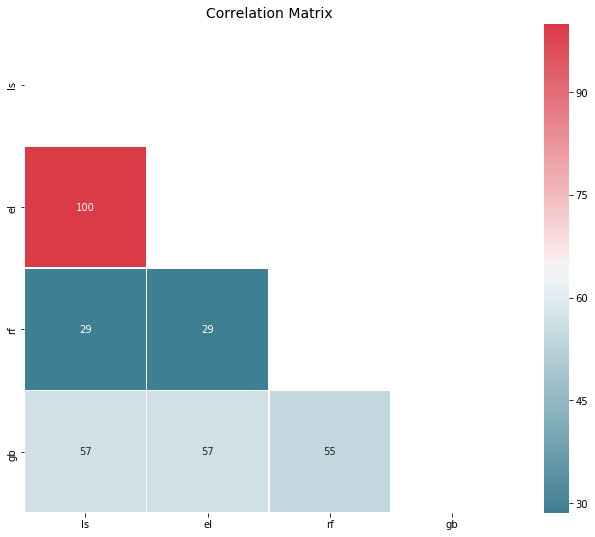

In [38]:
ax = corrmat(P.corr())
show()

In [39]:
param_dicts = {
    'ls':
    {'alpha': uniform(1e-6, 1e-5)},
    'el':
    {'alpha': uniform(1e-6, 1e-5),
     'l1_ratio': uniform(0, 1)
    },
    'gb':
    {'learning_rate': uniform(0.02, 0.04),
     'colsample_bytree': uniform(0.55, 0.66),
     'min_child_weight': randint(30, 60),
     'max_depth': randint(3, 7),
     'subsample': uniform(0.4, 0.2),
     'n_estimators': randint(150, 200),
     'colsample_bytree': uniform(0.6, 0.4),
     'reg_lambda': uniform(1, 2),
     'reg_alpha': uniform(1, 2),
    },
    'rf':
    {'max_depth': randint(2, 5),
     'min_samples_split': randint(5, 20),
     'min_samples_leaf': randint(10, 20),
     'n_estimators': randint(50, 100),
     'max_features': uniform(0.6, 0.3)
    }
}

In [40]:
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

evl = Evaluator(
    scorer,
    cv=2,
    random_state=SEED,
    verbose=5,
)

In [10]:
evl.fit(
    xtrain, ytrain,
    estimators=base_learners,
    param_dicts=param_dicts,
    preprocessing={'sc': [StandardScaler()], 'none': []},
    n_iter=2  # bump this up to do a larger grid search
)

Launching job
Preprocessing 2 preprocessing pipelines over 2 CV folds
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s finished
Preprocessing done | 00:00:00
Evaluating 8 models for 2 parameter draws over 2 preprocessing pipelines and 2 CV folds, totalling 32 fits
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    8.1s finished
Evaluation    done | 00:00:08
Job           done | 00:00:08


In [11]:
pd.DataFrame(evl.results)

,test_score-m,test_score-s,train_score-m,train_score-s,fit_time-m,fit_time-s,pred_time-m,pred_time-s,params
none.el,-0.831304,0.001624,-0.830968,0.003611,0.003865,0.000026,0.001317,0.000373,"{'alpha': 6.754058522312349e-06, 'l1_ratio': 0..."
none.gb,-0.786532,0.005006,-0.772718,0.006302,2.243716,0.020265,0.269248,0.006755,"{'learning_rate': 0.0430162340892494, 'colsamp..."
none.ls,-0.832389,0.001673,-0.832047,0.003626,0.002397,0.000427,0.000561,0.000013,{'alpha': 6.754058522312349e-06}
none.rf,-0.812146,0.004862,-0.808525,0.004002,0.985899,0.048487,0.074325,0.000262,"{'max_depth': 4, 'min_samples_split': 8, 'min_..."
sc.el,-0.831304,0.001624,-0.830968,0.003611,0.010035,0.005532,0.000737,0.000057,"{'alpha': 6.754058522312349e-06, 'l1_ratio': 0..."
sc.gb,-0.786491,0.005088,-0.772733,0.006283,1.993322,0.022101,0.359846,0.027755,"{'learning_rate': 0.0430162340892494, 'colsamp..."
sc.ls,-0.832389,0.001673,-0.832047,0.003626,0.005824,0.002260,0.000662,0.000067,{'alpha': 6.754058522312349e-06}
sc.rf,-0.812146,0.004864,-0.808523,0.004002,1.075177,0.045871,0.066675,0.003617,"{'max_depth': 4, 'min_samples_split': 8, 'min_..."


In [12]:
evl.results["params"]['sc.gb']

{'colsample_bytree': 0.830162340892494,
 'learning_rate': 0.0430162340892494,
 'max_depth': 6,
 'min_child_weight': 49,
 'n_estimators': 169,
 'reg_alpha': 2.1508117044624697,
 'reg_lambda': 2.1508117044624697,
 'subsample': 0.515081170446247}

In [13]:
for case_name, params in evl.results["params"].items():
    case, case_est = case_name.split('.')
    for est_name, est in base_learners:
        if est_name == case_est:
            est.set_params(**params)

In [14]:
# We will compare a GBM and an elastic net as the meta learner
# These are cloned internally so we can go ahead and grab the fitted ones
meta_learners = [
    ('gb', gb), ('rf', rf)
]

# Note that when we have a preprocessing pipeline,
# keys are in the (prep_name, est_name) format
param_dicts = {
    'rf':
    {'max_depth': randint(2, 5),
     'min_samples_split': randint(5, 20),
     'min_samples_leaf': randint(10, 20),
     'n_estimators': randint(50, 100),
     'max_features': uniform(0.6, 0.3)
    },
    'gb':
    {'learning_rate': uniform(0.01, 0.2),
     'subsample': uniform(0.5, 0.5),
     'reg_lambda': uniform(0.1, 1),
     'n_estimators': randint(10, 100)
    },
}

In [15]:
# Put the layers you don't want to tune into an ensemble with model selection turned on
# Just remember to turn it off when you're done!
in_layer = SuperLearner(model_selection=True)
in_layer.add(base_learners)

preprocess = [in_layer]

In [16]:
evl.fit(
    xtrain, ytrain,
    meta_learners,
    param_dicts,
    preprocessing={'meta': preprocess},
    n_iter=10                            # bump this up to do a larger grid search
)

Launching job
Preprocessing 1 preprocessing pipelines over 2 CV folds
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.0s finished
Preprocessing done | 00:00:04
Evaluating 2 models for 10 parameter draws over 1 preprocessing pipelines and 2 CV folds, totalling 40 fits
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.3min finished
Evaluation    done | 00:01:17
Job           done | 00:01:21


In [17]:
pd.DataFrame(evl.results)

,test_score-m,test_score-s,train_score-m,train_score-s,fit_time-m,fit_time-s,pred_time-m,pred_time-s,params
meta.gb,-0.790492,0.003870,-0.761135,0.008287,4.669716,0.077545,0.212733,0.116692,"{'learning_rate': 0.12515078243898003, 'subsam..."
meta.rf,-0.787718,0.003633,-0.787189,0.008167,7.000429,0.099820,0.135358,0.015563,"{'max_depth': 4, 'min_samples_split': 6, 'min_..."


In [19]:
# Let's pick the linear meta learner with the above tuned
# hyper-parameters. Note that ideally, you'd want to tune
# the ensemble as a whole, not each estimator at a time
meta_learner = meta_learners[1][1]
meta_learner.set_params(**evl.results["params"]["meta.rf"])

# We can grab the preprocessing layer and turn model selection off
ens = in_layer
ens.model_selection = False
ens.add_meta(meta_learner)

SuperLearner(array_check=2, backend=None, folds=2,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=None, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=2, raise_on_ex...rer=None)],
   n_jobs=-1, name='group-1', raise_on_exception=True, transformers=[])],
   verbose=0)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=None, sample_size=20, scorer=None, shuffle=False,
       verbose=False)

In [26]:
ens.fit(xtrain, ytrain)

SuperLearner(array_check=2, backend=None, folds=2,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=None, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=2, raise_on_ex...rer=None)],
   n_jobs=-1, name='group-1', raise_on_exception=True, transformers=[])],
   verbose=0)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=None, sample_size=20, scorer=None, shuffle=False,
       verbose=False)

In [31]:
pred = ens.predict(xtest)
pred = np.round(xtest)
print(pred)

[[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 1.]
 [0. 0.]
 [0. 1.]]


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(ytest, pred))

print("ensemble score: %.4f" % sqrt(mean_absolute_error(ytest, pred)))

In [23]:
Xtest = []
for i, row in testrecord.iterrows():
    x = (row['userId'], row['movieId'])
    Xtest.append(x)
    
scaler = MinMaxScaler()
scaler.fit(Xtest)
Xtest = scaler.transform(Xtest)

In [24]:
ens.fit(X, Y)
pred = ens.predict(Xtest)
print(pred[:100])

[4.0966206 3.8180976 4.129749  3.927098  4.0967283 3.9169328 3.9169328
 3.8988316 4.2452044 4.5055737 3.8988316 4.1335287 4.246747  4.1295705
 4.0474887 3.4668722 3.8988316 3.8988316 4.4231787 4.2466955 3.885539
 3.4668722 4.248605  4.148717  4.0966206 4.0966206 3.8988316 4.2452044
 4.142849  3.927098  3.8402336 3.8432646 4.106792  3.8325562 4.1153836
 3.7208478 3.8432646 4.1283455 4.115276  3.9100995 3.919994  3.9100995
 3.6284122 3.5978372 3.5637228 3.6118476 3.705442  3.703935  4.0967283
 3.8529475 3.6999109 3.8422434 3.8422434 3.5637228 3.5637228 3.5637228
 3.5637228 3.5978372 3.5978372 3.5978372 3.8180976 3.8180976 3.8180976
 4.122256  4.122256  4.122256  4.122256  3.6118476 3.8180976 3.8988316
 3.8422434 3.8458488 3.8402336 4.0845776 3.8988316 3.9169328 3.8988316
 3.5978372 3.906111  4.0811567 3.8988316 3.8988316 3.8988316 3.5978372
 3.473227  3.8259125 3.8259125 3.2866232 4.122256  3.8988316 4.1372733
 4.1372733 4.1372733 3.5978372 3.8180976 4.0966206 4.115276  4.0966206
 4.0966

In [25]:
np.savetxt('predictions.dat', pred, delimiter=" ", fmt="%s")